## 1. Scraping

In [3]:
from bs4 import BeautifulSoup
from pprint import pprint
import requests
import pandas as pd
url = "https://finviz.com/quote.ashx?t=GOOGL"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

html_tables =[]
for data in soup:
    data = soup.find(id='news-table')
    html_tables.append(data)

# html_tables

# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for news_table in html_tables:
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
#         print(date_scrape)
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
#         ticker = file_name.split('_')[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([date, time, x.a.text])

parsed_news

# table_data = []
# contentTable = soup.find(class_ = "fullview-news-outer")
# rows = contentTable.find_all('td')
# for row in rows:
#     data = row.get_text()
#     table_data.append(data)  
# length_of_data = len(table_data)
    

# headlines_dictionary = {}
# for i in range(0, length_of_data, 2):
#     time_date = table_data[i]
#     time_date_key = time_date.replace(u'\xa0', u' ').strip()
#     headline = table_data[i+1]
    
#     headlines_dictionary[time_date_key] = headline
    
# df = pd.DataFrame.from_dict(headlines_dictionary, orient = 'index')
# df.ffill(axis=1)
# df.head()

[['Oct-16-19',
  '03:36AM',
  'Huawei Defies U.S. Ban With Strong Growth in Smartphone Sales'],
 ['Oct-16-19', '02:03AM', 'Googles Pixel Gets Unorthodox Zoom From AI'],
 ['Oct-16-19',
  '01:02AM',
  'Marijuana stocks, after declines of over 50%, are now only ludicrously overpriced'],
 ['Oct-16-19',
  '12:45AM',
  "$30 Billion of Proof That India's Tech Scene Is Back"],
 ['Oct-15-19',
  '09:56PM',
  'House investigators say they have begun receiving data from big tech firms'],
 ['Oct-15-19',
  '09:46PM',
  'House investigators say they have begun receiving data from big tech firms'],
 ['Oct-15-19',
  '07:37PM',
  'Google, Reddit defend tech legal protections ahead of Congress hearing'],
 ['Oct-15-19', '06:17PM', 'Fintech Stocks For Your Portfolio Of The Future'],
 ['Oct-15-19',
  '05:08PM',
  'Latest Victim in Zero Sum World Is a Russian Internet Giant'],
 ['Oct-15-19', '04:56PM', 'Is the IPO Party Over? ETFs in Focus'],
 ['Oct-15-19',
  '04:11PM',
  'Google Stock Rises On Pixel 4 Debut

## 2. Sentiment Analysis

In [4]:
# NLTK VADER for sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
# nltk.download('stopwords')
vader.lexicon.update(new_words)

     |████████████████████████████████| 133kB 6.1MB/s eta 0:00:01


## 3. Collating

In [5]:
# Use these column names
columns = ['date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news,columns=columns)
scored_news.head(20)
# Iterate through the headlines and get the polarity scores
# for news in parsed_news:
#     print(news[2])
scores = [vader.polarity_scores(news[2]) for news in parsed_news]
# print(scores)
# # # # Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# print(scores_df)
# # # # Join the DataFrames
scored_news = scored_news.join(scores_df)
# # # # Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
scored_news
# len(scored_news)

,date,time,headline,compound,neg,neu,pos
0,2019-10-16,03:36AM,Huawei Defies U.S. Ban With Strong Growth in S...,0.3182,0.218,0.424,0.358
1,2019-10-16,02:03AM,Googles Pixel Gets Unorthodox Zoom From AI,0.0000,0.000,1.000,0.000
2,2019-10-16,01:02AM,"Marijuana stocks, after declines of over 50%, ...",-0.0516,0.098,0.902,0.000
3,2019-10-16,12:45AM,$30 Billion of Proof That India's Tech Scene I...,0.0000,0.000,1.000,0.000
4,2019-10-15,09:56PM,House investigators say they have begun receiv...,0.0000,0.000,1.000,0.000
5,2019-10-15,09:46PM,House investigators say they have begun receiv...,0.0000,0.000,1.000,0.000
6,2019-10-15,07:37PM,"Google, Reddit defend tech legal protections a...",0.1280,0.000,0.857,0.143
7,2019-10-15,06:17PM,Fintech Stocks For Your Portfolio Of The Future,0.0000,0.000,1.000,0.000
8,2019-10-15,05:08PM,Latest Victim in Zero Sum World Is a Russian I...,-0.2732,0.189,0.811,0.000
9,2019-10-15,04:56PM,Is the IPO Party Over? ETFs in Focus,0.4019,0.000,0.722,0.278


## 4. Plotting

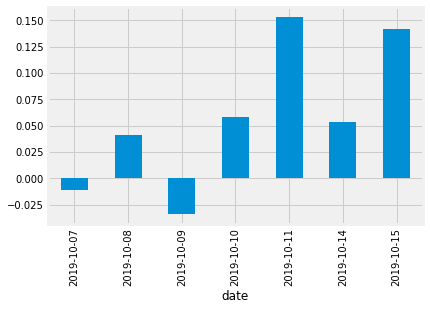

In [99]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date']).mean()

mean_c = tri_plot
# display(mean_c.head())
# Unstack the column ticker
mean_c = mean_c.unstack(1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c['compound']
# Plot a bar chart with pandas
mean_c.head()
mean_c.plot.bar()

In [6]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = len(scored_news)
# sum(scored_news.duplicated(subset=['headline']))
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset = ['headline'])
# Count number of headlines after dropping duplicates
num_news_after = len(scored_news_clean)
# Print before and after numbers to get an idea of how we did 
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")
scored_news_clean

Before we had 6700 headlines, now we have 96


,date,time,headline,compound,neg,neu,pos
0,2019-10-16,03:36AM,Huawei Defies U.S. Ban With Strong Growth in S...,0.3182,0.218,0.424,0.358
1,2019-10-16,02:03AM,Googles Pixel Gets Unorthodox Zoom From AI,0.0000,0.000,1.000,0.000
2,2019-10-16,01:02AM,"Marijuana stocks, after declines of over 50%, ...",-0.0516,0.098,0.902,0.000
3,2019-10-16,12:45AM,$30 Billion of Proof That India's Tech Scene I...,0.0000,0.000,1.000,0.000
4,2019-10-15,09:56PM,House investigators say they have begun receiv...,0.0000,0.000,1.000,0.000
6,2019-10-15,07:37PM,"Google, Reddit defend tech legal protections a...",0.1280,0.000,0.857,0.143
7,2019-10-15,06:17PM,Fintech Stocks For Your Portfolio Of The Future,0.0000,0.000,1.000,0.000
8,2019-10-15,05:08PM,Latest Victim in Zero Sum World Is a Russian I...,-0.2732,0.189,0.811,0.000
9,2019-10-15,04:56PM,Is the IPO Party Over? ETFs in Focus,0.4019,0.000,0.722,0.278
10,2019-10-15,04:11PM,Google Stock Rises On Pixel 4 Debut; Big Four ...,0.0000,0.000,1.000,0.000


In [11]:
# # Set the index to ticker and date
# single_day = scored_news_clean.set_index(['date'])
group_by_day = scored_news_clean.groupby(['date',]).mean()
# # Select the 3rd of January of 2019
# single_day = single_day.loc['2019-10-14',]
print(group_by_day)
# # Convert the datetime string to just the time
# single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# # Set the index to time and 
# single_day = single_day.set_index('time')
# # Sort it
# single_day = single_day.sort_index()
# single_day

            compound       neg       neu       pos
date                                              
2019-10-09  0.127211  0.000000  0.934333  0.065667
2019-10-10  0.061250  0.041250  0.871100  0.087650
2019-10-11  0.164214  0.027429  0.860143  0.112429
2019-10-14  0.051386  0.050000  0.877182  0.072864
2019-10-15  0.061863  0.007000  0.940963  0.052037
2019-10-16  0.066650  0.079000  0.831500  0.089500


In [ ]:
# random forest classifier

In [ ]:
# google prices over 8 days -> target variable